In [13]:
import pandas as pd
import seaborn as sns
from idx2numpy import convert_from_file
from sklearn.utils import shuffle

from principal_RBM_alpha import *
from principal_DBN_alpha import *
from principal_DNN_MNIST import *

sns.set_theme()

## 1. Etude sur Binary AlphaDigit

### 1.1. RBM

In [14]:
#Cahrge les données
data_path = "data/"
alphadigs_path = data_path + "binaryalphadigs.mat"

indices = [3]
p, q = 320, 30
nb_iter = 200
alpha = 0.1
batch_size = 10
nb_iter_gibbs = 1000

In [15]:
X = lire_alpha_digit(alphadigs_path, indices) 
X.shape

(39, 320)

Iteration RBM (0/200) 	  MSE : 0.1745
Iteration RBM (100/200) 	  MSE : 0.0752


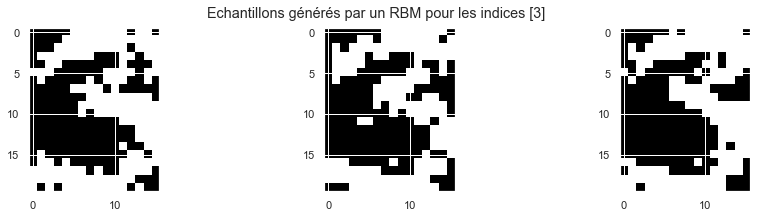

In [16]:
#RBM
#initialisation
rbm = RBM(p, q)
#train
rbm, losses = train_RBM(rbm, X, nb_iter, batch_size, alpha)
#Test
imgs = generer_image_RBM(rbm, nb_iter_gibbs, 3, indices)

### 1.2. DBN

In [17]:
# Parameters
idx = [6, 33]
data = lire_alpha_digit(alphadigs_path, idx)
dim_inp = data.shape[1]
dim_out = 200
dim_hid_lst = [230, 350, 220]
batch_size = 15
n_iter = 50
lr = 0.01

Pré-entrainement de la couche (1/4) du DNN
Iteration RBM (0/50) 	  MSE : 0.1827
Pré-entrainement de la couche (2/4) du DNN
Iteration RBM (0/50) 	  MSE : 0.0937
Pré-entrainement de la couche (3/4) du DNN
Iteration RBM (0/50) 	  MSE : 0.0688
Pré-entrainement de la couche (4/4) du DNN
Iteration RBM (0/50) 	  MSE : 0.0876


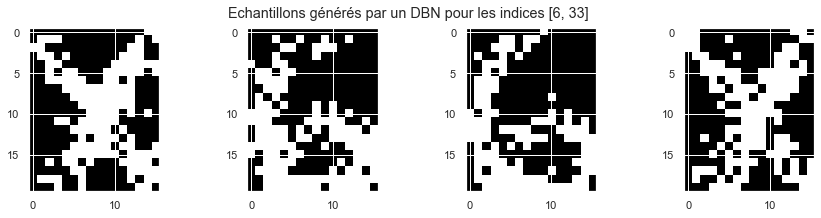

In [18]:
dnn = DNN(dim_inp, dim_out, dim_hid_lst)
dnn_trained = pretrain_DNN(dnn, data, n_iter, batch_size, lr)
images = generer_image_DBN(dnn_trained, n_imgs=4, n_iter=n_iter, indices=idx)

## 2. Etude sur MNIST

### 2.1. Preprocessing des données

In [19]:
mnist_train_file = 'train-images.idx3-ubyte'
mnist_train_label_file = 'train-labels.idx1-ubyte'
mnist_test_file = 't10k-images.idx3-ubyte'
mnist_test_label_file = 't10k-labels.idx1-ubyte'

In [21]:
def get_MNIST_data():
  # Lire les fichiers
  X_train = convert_from_file(data_path + mnist_train_file)
  y_train = convert_from_file(data_path + mnist_train_label_file)
  X_test = convert_from_file(data_path + mnist_test_file)
  y_test = convert_from_file(data_path + mnist_test_label_file)

  # Pour chaque image on convertit la matrice correspondante en vecteur
  X_train = np.array([img.flatten() for img in X_train])
  X_test = np.array([img.flatten() for img in X_test])

  # Binariser les images
  X_train = 1 * (X_train > 127) 
  X_test = 1 * (X_test > 127) 

  # Formatter les labels
  def encode_labels(y):
	# Pour chaque image le label est un entier
	# on le transforme en vecteur dont les éléments
	# valent 0 sauf celui à l'indice du label qui vaut 1
    n = y.shape[0]
    y_ = np.zeros((n, y.max() + 1)) 
    y_[np.arange(n), y] = 1
    return y_

  y_train = encode_labels(y_train)
  y_test = encode_labels(y_test)

  # On mélange les données
  X_train, y_train = shuffle(X_train, y_train)
  X_test, y_test = shuffle(X_test, y_test)

  return X_train, y_train, X_test, y_test

In [22]:
X_train, y_train, X_test, y_test = get_MNIST_data()

print("Dimension de X_train :", X_train.shape)
print("Dimension de y_train :", y_train.shape)
print('-' * 50)
print("Dimension de X_test :", X_test.shape)
print("Dimension de y_test :", y_test.shape)

Dimension de X_train : (60000, 784)
Dimension de y_train : (60000, 10)
--------------------------------------------------
Dimension de X_test : (10000, 784)
Dimension de y_test : (10000, 10)


### 2.2. Définition d'une classe pour l'analyse

In [23]:
# Paramètres
n_iter_rbm = 50               # nbre d'itérations pour les RBM
n_iter_backprop = 100          # dnn iterations
learning_rate = 0.1            # learning rate
batch_size = 32                # batch size

in_dim = X_train.shape[1]      # taille d'une image
out_dim = 10                   # nbre de classes du MNIST dataset

N_total = X_train.shape[0]     # taille des données d'apprentissage

In [24]:
class SingleAnalysis():

    def __init__(self, N=N_total, hidden_dims=[200, 200], n_iter_rbm=n_iter_rbm, n_iter_backprop=n_iter_backprop,
        learning_rate=learning_rate, batch_size=batch_size, out_dim=out_dim):

        print(f"ANALYSE DES RESEAUX POUR N = {N} et les couches {hidden_dims}")
        print('-' * 100)
        self.hidden_dims = hidden_dims
        self.N = N                          # taille des données pour l'apprentissage
        n = int(self.N / 5)                 # taille des données pour le pré-apprentissage

        # Initialisation des données d'apprentissage
        X_train_ = X_train[:self.N, :]
        y_train_ = y_train[:self.N, :]

        # Initialisation de deux réseaux identiques
        self.pretrained_dnn = DNN(in_dim, out_dim, hidden_dims)
        self.dnn = DNN(in_dim, out_dim, hidden_dims)

        print("Pré-apprentissage du premier réseau")
        print('-' * 70)
        self.pretrained_dnn = pretrain_DNN(dnn=self.pretrained_dnn, X=X_train_[:n], 
                                    nb_iter=n_iter_rbm,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate
        )

        print("\n Apprentissage du premier réseau")
        print('-' * 70)
        self.pretrained_dnn, pretrained_losses = retropropagation(dnn=self.pretrained_dnn,
                                                        X=X_train_, y=y_train_,
                                                        batch_size=batch_size,
                                                        n_iter=n_iter_backprop,
                                                        learning_rate=learning_rate
        )

        print("\n Apprentissage du deuxième réseau")
        print('-' * 70)
        self.dnn, losses = retropropagation(dnn=self.dnn, X=X_train_, y=y_train_,
                                    batch_size=batch_size,
                                    n_iter=n_iter_backprop,
                                    learning_rate=learning_rate
        )

        self.final_loss = losses[-1]
        self.pre_final_loss = pretrained_losses[-1]

        # Calcul du taux d'erreur sur les données d'apprentissage
        self.pre_acc_train = test_DNN(dnn=self.pretrained_dnn, X=X_train, y=y_train)
        self.acc_train = test_DNN(dnn=self.dnn, X=X_train, y=y_train)

        # Calcul du taux d'erreur sur les données de test
        self.pre_acc_test = test_DNN(dnn=self.pretrained_dnn, X=X_test, y=y_test)
        self.acc_test = test_DNN(dnn=self.dnn, X=X_test, y=y_test)

    def performance(self):
        return self.pre_acc_train, self.acc_train, self.pre_acc_test, self.acc_test


### 2.3. Exemple pour $N=1000$ et $hidden\_dims=[200, 200]$

In [25]:
# ex_analysis = SingleAnalysis(N=1000)

On obtient les performances suivantes:

In [26]:
# print("Réseau pré-entraîné")
# print('-' * 30)
# print(f"Cross-entropy train : {ex_analysis.pre_final_loss:.4f}")
# print(f"Train Accuracy : {(ex_analysis.pre_acc_train)*100 : .2f} %")
# print(f"Test Accuracy : {(ex_analysis.pre_acc_test)*100 : .2f} % \n")

# print("Réseau entraîné")
# print('-' * 30)
# print(f"Cross-entropy train : {ex_analysis.final_loss:.4f}")
# print(f"Train Accuracy : {(ex_analysis.acc_train)*100 : .2f} %")
# print(f"Test Accuracy : {(ex_analysis.acc_test)*100 : .2f} % \n")

Meilleures performances pour le réseau pré-entraîné.

In [27]:
columns = [
    "Train Accuracy (pretrained)",
    "Train Accuracy",
    "Test Accuracy (pretrained)",
    "Test Accuracy",
]

### 2.4. Analyse de l'influence du nombre de couches cachées

In [37]:
class AnalysisNLayers():

    def __init__(self, n_layer_list):
        self.n_layer_list = n_layer_list

        # initialisation d'un dataframe pour les results
        self.results = pd.DataFrame(
            index = n_layer_list,
            columns = columns
        ).rename_axis("n_layers")

        # Pour chaque valeur dans la liste n_layer_list
        for n_layer in n_layer_list:
            hidden_dims = [200] * n_layer
            analysis_ = SingleAnalysis(hidden_dims=hidden_dims)
            performance_analysis = analysis_.performance()
            self.results.loc[n_layer] = performance_analysis
    
    def plot_train_results(self):
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Train Accuracy (pretrained)",
                    label="Train Accuracy (pretrained)"
        )
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Train Accuracy",
                    label="Train Accuracy"
        )
        plt.title("Taux d'erreur sur les données d'apprentissage en fonction du nombre de couche")
        plt.show()

    def plot_test_results(self):
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Test Accuracy (pretrained)",
                    label="Test Accuracy (pretrained)"
        )
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Test Accuracy",
                    label="Test Accuracy"
        )
        plt.title("Taux d'erreur sur les données de test en fonction du nombre de couche")
        plt.show()

In [38]:
analysis_n_layers = AnalysisNLayers(range(2,6))

ANALYSE DES RESEAUX POUR N = 60000 et les couches [200, 200]
----------------------------------------------------------------------------------------------------
Pré-apprentissage du premier réseau
----------------------------------------------------------------------
Pré-entrainement de la couche (1/3) du DNN
Iteration RBM (0/50) 	  MSE : 0.0330
Pré-entrainement de la couche (2/3) du DNN
Iteration RBM (0/50) 	  MSE : 0.0613
Pré-entrainement de la couche (3/3) du DNN
Iteration RBM (0/50) 	  MSE : 0.0925

 Apprentissage du premier réseau
----------------------------------------------------------------------
Iteration Rétropropagation (0/100) 	 cross_entropy : 0.4433


In [ ]:
analysis_n_layers.plot_train_results()

In [ ]:
analysis_n_layers.plot_test_results()

### 2.5. Analyse de l'influence du nombre de neurones par couche

In [41]:
class AnalysisNUnits():

    def __init__(self, n_units_list):
        self.n_units_list = n_units_list

        # initialisation d'un dataframe pour les results
        self.results = pd.DataFrame(
            index = n_units_list,
            columns = columns
        ).rename_axis("n_units")

        # Pour chaque valeur dans la liste n_units_list
        for n_units in n_units_list:
            hidden_dims = [n_units] * 2
            analysis_ = SingleAnalysis(hidden_dims=hidden_dims)
            performance_analysis = analysis_.performance()
            self.results.loc[n_units] = performance_analysis
    
    def plot_train_results(self):
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Train Accuracy (pretrained)",
                    label="Train Accuracy (pretrained)"
        )
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Train Accuracy",
                    label="Train Accuracy"
        )
        plt.title("Taux d'erreur sur les données d'apprentissage en fonction du nombre de neurones par couche")
        plt.show()

    def plot_test_results(self):
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Test Accuracy (pretrained)",
                    label="Test Accuracy (pretrained)"
        )
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Test Accuracy",
                    label="Test Accuracy"
        )
        plt.title("Taux d'erreur sur les données de test en fonction du nombre de neurones par couche")
        plt.show()

In [ ]:
analysis_n_units_2_5 = AnalysisNUnits(range(100, 800, 100))

ANALYSE DES RESEAUX POUR N = 60000 et les couches [100, 100]
----------------------------------------------------------------------------------------------------
Pré-apprentissage du premier réseau
----------------------------------------------------------------------
Pré-entrainement de la couche (1/3) du DNN
Iteration RBM (0/50) 	  MSE : 0.0409
Pré-entrainement de la couche (2/3) du DNN
Iteration RBM (0/50) 	  MSE : 0.0882
Pré-entrainement de la couche (3/3) du DNN
Iteration RBM (0/50) 	  MSE : 0.0897

 Apprentissage du premier réseau
----------------------------------------------------------------------
Iteration Rétropropagation (0/100) 	 cross_entropy : 0.4458
Iteration Rétropropagation (10/100) 	 cross_entropy : 0.1516
Iteration Rétropropagation (20/100) 	 cross_entropy : 0.1050
Iteration Rétropropagation (30/100) 	 cross_entropy : 0.0760
Iteration Rétropropagation (40/100) 	 cross_entropy : 0.0593
Iteration Rétropropagation (50/100) 	 cross_entropy : 0.0480
Iteration Rétropropag

In [ ]:
analysis_n_units.plot_train_results()

In [ ]:
analysis_n_units.plot_test_results()

### 2.6. Analyse de l'influence de la taille des données d'entraînement

In [28]:
class AnalysisNTrain():

    def __init__(self, n_train_list):
        self.n_train_list = n_train_list

        # initialisation d'un dataframe pour les results
        self.results = pd.DataFrame(
            index = n_train_list,
            columns = columns
        ).rename_axis("n_train")

        # Pour chaque valeur dans la liste n_train_list
        for n_train in n_train_list:
            analysis_ = SingleAnalysis(N=n_train)
            performance_analysis = analysis_.performance()
            self.results.loc[n_train] = performance_analysis
    
    def plot_train_results(self):
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Train Accuracy (pretrained)",
                    label="Train Accuracy (pretrained)"
        )
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Train Accuracy",
                    label="Train Accuracy"
        )
        plt.title("Taux d'erreur sur les données d'apprentissage en fonction de leur taille")
        plt.show()

    def plot_test_results(self):
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Test Accuracy (pretrained)",
                    label="Test Accuracy (pretrained)"
        )
        sns.lineplot(data=self.results, x=self.results.index,
                    y="Test Accuracy",
                    label="Test Accuracy"
        )
        plt.title("Taux d'erreur sur les données de test en fonction de la taille des données d'apprentissage")
        plt.show()

In [29]:
n_train_list = [1000, 3000, 7000, 10000, 30000, 60000]
analysis_n_train = AnalysisNTrain(n_train_list)

ANALYSE DES RESEAUX POUR N = 1000 et les couches [200, 200]
----------------------------------------------------------------------------------------------------
Pré-apprentissage du premier réseau
----------------------------------------------------------------------
Pré-entrainement de la couche (1/3) du DNN
Iteration RBM (0/50) 	  MSE : 0.0886
Pré-entrainement de la couche (2/3) du DNN
Iteration RBM (0/50) 	  MSE : 0.1439
Pré-entrainement de la couche (3/3) du DNN
Iteration RBM (0/50) 	  MSE : 0.1524

 Apprentissage du premier réseau
----------------------------------------------------------------------
Iteration Rétropropagation (0/100) 	 cross_entropy : 5.1858
Iteration Rétropropagation (10/100) 	 cross_entropy : 0.6316
Iteration Rétropropagation (20/100) 	 cross_entropy : 0.3978
Iteration Rétropropagation (30/100) 	 cross_entropy : 0.2801
Iteration Rétropropagation (40/100) 	 cross_entropy : 0.2108
Iteration Rétropropagation (50/100) 	 cross_entropy : 0.1617
Iteration Rétropropaga


 Apprentissage du premier réseau
----------------------------------------------------------------------
Iteration Rétropropagation (0/100) 	 cross_entropy : 0.5173
Iteration Rétropropagation (10/100) 	 cross_entropy : 0.1461
Iteration Rétropropagation (20/100) 	 cross_entropy : 0.0871
Iteration Rétropropagation (30/100) 	 cross_entropy : 0.0567
Iteration Rétropropagation (40/100) 	 cross_entropy : 0.0382
Iteration Rétropropagation (50/100) 	 cross_entropy : 0.0266
Iteration Rétropropagation (60/100) 	 cross_entropy : 0.0198
Iteration Rétropropagation (70/100) 	 cross_entropy : 0.0147
Iteration Rétropropagation (80/100) 	 cross_entropy : 0.0116
Iteration Rétropropagation (90/100) 	 cross_entropy : 0.0092

 Apprentissage du deuxième réseau
----------------------------------------------------------------------
Iteration Rétropropagation (0/100) 	 cross_entropy : 0.4840
Iteration Rétropropagation (10/100) 	 cross_entropy : 0.1602
Iteration Rétropropagation (20/100) 	 cross_entropy : 0.078

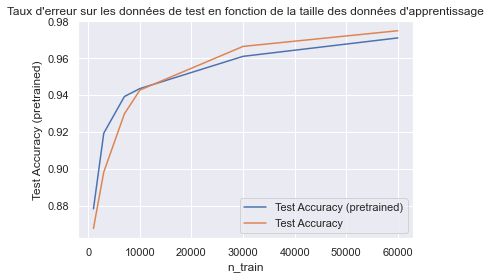

In [30]:
analysis_n_train.plot_test_results()

In [33]:
import pickle

with open('2_6_out', 'wb') as f1:
    pickle.dump(analysis_n_train, f1)

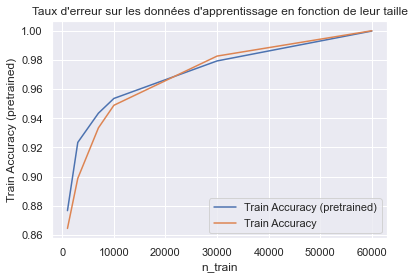

In [34]:
analysis_n_train.plot_train_results()

In [37]:
analysis_n_train.results

,Train Accuracy (pretrained),Train Accuracy,Test Accuracy (pretrained),Test Accuracy
n_train,,,,
1000,0.876583,0.864383,0.8782,0.8676
3000,0.923383,0.898733,0.9193,0.8982
7000,0.943433,0.933367,0.9392,0.9298
10000,0.95355,0.948867,0.9435,0.9427
30000,0.979283,0.982617,0.961,0.9664
60000,0.9998,1.0,0.971,0.9749


In [40]:
analysis_n_train.results.to_csv('2_6_out.zip')